## Timeseries Data

Go over using Time Series MongoDB collections by scraping stock market data over the internet

##### Install Dependencies In Terminal (if you do not already have it)
```bash
pip install --user yfinance
pip install --user matplotlib
```

In [1]:
from pymongo import MongoClient

import pandas
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### Intro to yfinance

In [2]:
tickers = ["AMZN", "GOOGL"]
data = yf.download(tickers=tickers, period="1y", interval="1d")

[*********************100%***********************]  2 of 2 completed


In [3]:
print(type(data))
data[0:3]

<class 'pandas.core.frame.DataFrame'>


Adj Close                   Close                    High  \
                  AMZN       GOOGL        AMZN       GOOGL        AMZN   
Date                                                                     
2022-04-11  151.121994  128.823502  151.121994  128.823502  154.136505   
2022-04-12  150.787506  127.714500  150.787506  127.714500  155.098999   
2022-04-13  155.541000  129.893997  155.541000  129.893997  156.024994   

                               Low                    Open              \
                 GOOGL        AMZN       GOOGL        AMZN       GOOGL   
Date                                                                     
2022-04-11  132.092499  150.534500  128.668503  152.712997  131.823502   
2022-04-12  131.600006  150.382996  126.789001  153.692505  131.600006   
2022-04-13  130.334000  149.600006  127.740997  150.018494  128.000000   

              Volume            
                AMZN     GOOGL  
Date                            
2022-04-11  52112000  36884000  
2022-04-12  55178000  32710000  
2022-04-13  53390000  27928000

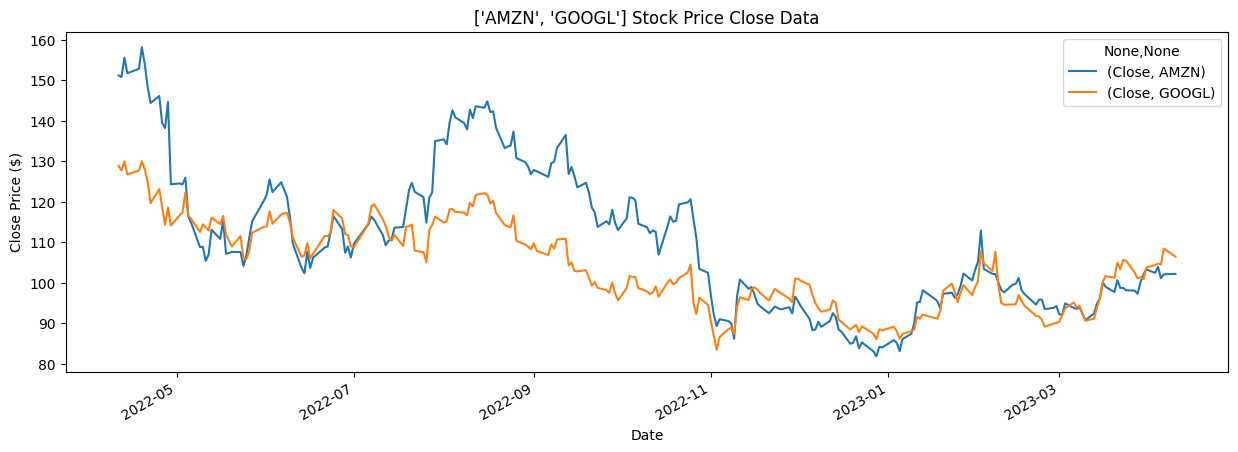

In [4]:
ax = data.plot(y=["Close"], figsize=(15, 5), title=str(tickers) + " Stock Price Close Data")
ax.set_ylabel("Close Price ($)")
None

### Converting yfinance dataframe to dict format for insertion

##### Swap the columns so the ticker names are the highest level column

In [5]:
data.columns = data.columns.swaplevel(0,1)
data[0:3]

,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL
,Adj Close,Adj Close,Close,Close,High,High,Low,Low,Open,Open,Volume,Volume
Date,,,,,,,,,,,,
2022-04-11,151.121994,128.823502,151.121994,128.823502,154.136505,132.092499,150.534500,128.668503,152.712997,131.823502,52112000,36884000
2022-04-12,150.787506,127.714500,150.787506,127.714500,155.098999,131.600006,150.382996,126.789001,153.692505,131.600006,55178000,32710000
2022-04-13,155.541000,129.893997,155.541000,129.893997,156.024994,130.334000,149.600006,127.740997,150.018494,128.000000,53390000,27928000


In [6]:
data["AMZN"][0:3]

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-04-11,151.121994,151.121994,154.136505,150.534500,152.712997,52112000
2022-04-12,150.787506,150.787506,155.098999,150.382996,153.692505,55178000
2022-04-13,155.541000,155.541000,156.024994,149.600006,150.018494,53390000


##### Create an attribute an each entry that has the name of the ticker

In [7]:
for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker

In [8]:
data["GOOGL"][0:3]

,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
2022-04-11,128.823502,128.823502,132.092499,128.668503,131.823502,36884000,GOOGL
2022-04-12,127.714500,127.714500,131.600006,126.789001,131.600006,32710000,GOOGL
2022-04-13,129.893997,129.893997,130.334000,127.740997,128.000000,27928000,GOOGL


##### Set date index to a column 

In [9]:
data["AMZN"].reset_index(level=0)[0:3]

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
0,2022-04-11,151.121994,151.121994,154.136505,150.534500,152.712997,52112000,AMZN
1,2022-04-12,150.787506,150.787506,155.098999,150.382996,153.692505,55178000,AMZN
2,2022-04-13,155.541000,155.541000,156.024994,149.600006,150.018494,53390000,AMZN


##### Convert the dataframe to an array of dictionaries 

In [10]:
data["AMZN"].reset_index(level=0).to_dict('records')[0:2]

[{'Date': Timestamp('2022-04-11 00:00:00'),
  'Adj Close': 151.1219940185547,
  'Close': 151.1219940185547,
  'High': 154.13650512695312,
  'Low': 150.5345001220703,
  'Open': 152.71299743652344,
  'Volume': 52112000,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2022-04-12 00:00:00'),
  'Adj Close': 150.78750610351562,
  'Close': 150.78750610351562,
  'High': 155.0989990234375,
  'Low': 150.38299560546875,
  'Open': 153.6925048828125,
  'Volume': 55178000,
  'Ticker': 'AMZN'}]

### Connect To MongoDB instance

In [11]:
mongodb_uri = "mongodb://localhost:27017/"
db_name = "advanced_features"

In [12]:
client = MongoClient(mongodb_uri)
db = client[db_name]

### Creating  A Time-Series Collection

You could also use the compass app or mongoshell

In [13]:
db.create_collection("historical_stock_data", timeseries= {
        "timeField": "Date",
        "metaField": "Ticker",
        "granularity": "hours"
        }, expireAfterSeconds= 60 * 60 * 24 * 365 ### 1 year 
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'advanced_features'), 'historical_stock_data')

### Inserting The Time-Series Stock Data

##### Download the data

In [15]:
tickers = ["AMZN", "META", "GOOGL", "MSFT", "UDMY"]
data = yf.download(tickers=tickers, period="2y", interval="1d")

[*********************100%***********************]  5 of 5 completed


##### Process dataframe into list of dictionaries

In [16]:
stock_data_to_insert = []

data.columns = data.columns.swaplevel(0,1)

for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker
    stock_data_to_insert.extend(data[ticker].reset_index(level=0).to_dict('records'))

In [17]:
stock_data_to_insert[0:2]

[{'Date': Timestamp('2021-04-12 00:00:00'),
  'Adj Close': 168.96949768066406,
  'Close': 168.96949768066406,
  'High': 169.7519989013672,
  'Low': 167.5574951171875,
  'Open': 167.760498046875,
  'Volume': 65636000,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2021-04-13 00:00:00'),
  'Adj Close': 170.0,
  'Close': 170.0,
  'High': 171.60000610351562,
  'Low': 169.781494140625,
  'Open': 170.04249572753906,
  'Volume': 66316000,
  'Ticker': 'AMZN'}]

##### Call insert_many() on time series collection

In [18]:
db.historical_stock_data.insert_many(stock_data_to_insert)

### Retrieving Time-Series Data

In [19]:
gt_date = datetime.now() - relativedelta(months=6)
gt_date

datetime.datetime(2022, 10, 10, 18, 26, 1, 251966)

In [20]:
ts_cursor = db.historical_stock_data.find({"Ticker": "META", "Date": {"$gte": gt_date} })

fb_price_data = []

for entry in ts_cursor:
    fb_price_data.append(entry)
    
print(fb_price_data[0:2])

[{'Date': datetime.datetime(2022, 10, 11, 0, 0), 'Ticker': 'META', '_id': ObjectId('6434a916c3349a5edc62809a'), 'Low': 126.98999786376953, 'Open': 131.6199951171875, 'Volume': 38481400, 'Close': 128.5399932861328, 'Adj Close': 128.5399932861328, 'High': 132.66000366210938}, {'Date': datetime.datetime(2022, 10, 12, 0, 0), 'Ticker': 'META', '_id': ObjectId('6434a916c3349a5edc62809b'), 'Low': 126.25, 'Open': 128.32000732421875, 'Volume': 34605200, 'Close': 127.5, 'Adj Close': 127.5, 'High': 129.6699981689453}]


In [21]:
read_in_data = pandas.DataFrame(fb_price_data)
read_in_data = read_in_data.set_index("Date")
read_in_data = read_in_data.drop("_id", axis=1)

read_in_data

,Ticker,Low,Open,Volume,Close,Adj Close,High
Date,,,,,,,
2022-10-11,META,126.989998,131.619995,38481400,128.539993,128.539993,132.660004
2022-10-12,META,126.250000,128.320007,34605200,127.500000,127.500000,129.669998
2022-10-13,META,122.529999,123.529999,34325700,130.289993,130.289993,131.139999
2022-10-14,META,126.519997,131.000000,23559400,126.760002,126.760002,131.789993
2022-10-17,META,130.179993,130.300003,29612200,134.039993,134.039993,134.789993
...,...,...,...,...,...,...,...
2023-04-03,META,208.199997,208.839996,17924600,213.070007,213.070007,213.490005
2023-04-04,META,212.539993,213.389999,21026400,214.720001,214.720001,216.240005
2023-04-05,META,209.940002,214.149994,19396600,211.479996,211.479996,215.190002
